In [1]:

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.datasets import make_moons



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

def make_moon_dataset(num_sample = 100, noise = 0.15):
    # Generate the moons dataset
    X, y = make_moons(n_samples=num_sample, noise=noise, random_state=42)

    # Plot the dataset
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Moons Dataset")
    
widgets.interact(make_moon_dataset, num_sample = (100, 1000, 50), noise = (0.05, 1, 0.05))

interactive(children=(IntSlider(value=100, description='num_sample', max=1000, min=100, step=50), FloatSlider(…

<function __main__.make_moon_dataset(num_sample=100, noise=0.15)>

# Rotating the plot

In [4]:

# Function to rotate a dataset by a specified angle
def rotate_dataset(X, angle_degrees):
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Create a rotation matrix
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                 [np.sin(angle_radians), np.cos(angle_radians)]])
    
    # Apply the rotation to the dataset
    rotated_X = X.dot(rotation_matrix)
    
    return rotated_X

# List of angles in degrees by which to rotate the dataset

def plot_rotated_moon_dataset(num_samples = 100, noise = 0, rotated_angle = 0):
    X, y = make_moons(n_samples = num_samples, noise=noise, random_state=42)
    rotated_X = rotate_dataset(X, rotated_angle)
    plt.scatter(rotated_X[:, 0], rotated_X[:, 1], c = y, cmap=plt.cm.RdYlBu)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(f"Rotation by {rotated_angle} degree")

widgets.interact(plot_rotated_moon_dataset, num_samples = (100, 1000, 100), noise = (0, 1, 0.05), rotated_angle = (0, 360, 5))

interactive(children=(IntSlider(value=100, description='num_samples', max=1000, min=100, step=100), FloatSlide…

<function __main__.plot_rotated_moon_dataset(num_samples=100, noise=0, rotated_angle=0)>

# Model Initialization  

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = F.sigmoid(self.layers[-1](x))
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output


# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(3, 256)
#         self.fc2 = nn.Linear(256, 256)
#         self.fc3 = nn.Linear(256, 256)
#         self.fc6 = nn.Linear(256, 128)

        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc6(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(130, 256)
#         self.fc2 = nn.Linear(256, 256)
#         self.fc5 = nn.Linear(256, 256)
#         self.fc6 = nn.Linear(256, 1)
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x= F.relu(self.fc5(x))
#         x = F.sigmoid(self.fc6(x))
#         return x

# class Aggregator(nn.Module):
#     def __init__(self):
#         super(Aggregator, self).__init__()
        
#     def forward(self, x):
#         return torch.mean(x, dim=0)

# class cnp(nn.Module):
#     def __init__(self):
#         super(cnp, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
#         self.aggregator = Aggregator()
        
#     def forward(self, contextx, contexty, targetx):
#         context = torch.cat([contextx, contexty.unsqueeze(1)], dim=1)
#         encoded_context = self.encoder(context)
#         aggregated = self.aggregator(encoded_context)
#         decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 2)], dim=1)
#         output = self.decoder(decoder_input)
#         return output
    



# Training The Make moons Dataset

100%|██████████| 1000/1000 [00:01<00:00, 590.41it/s]


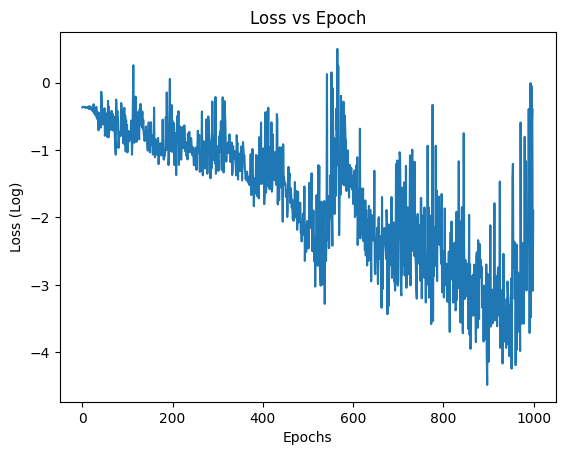

In [26]:
# make random 100 angles between 0 and 360

def take_random_angles(size = 100):
    return np.random.randint(0, 361, size)
# angles=[i for i in range(0,360,3)]
# 
# print(len(angles))

# select 100 random angles from the list of 120 angles

# angles=np.random.choice(angles,100)


def generate_make_moons(num_samples, angle, noise = 0.15):
    X, y = make_moons(n_samples=num_samples, noise=noise, random_state=42)
    X = rotate_dataset(X, angle)
    return X, y

def train_make_moons(num_epochs = 1000):
    # model and loss initialization
    
    encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    angles_count = 100
    angles = take_random_angles(angles_count)

    num_samples = 150
    training_data =[generate_make_moons(num_samples, angles[i]) for i in range(angles_count)]

    
    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, 50, replace=False)
        target=np.random.choice(num_samples, 100, replace=False)
        train_set=np.random.randint(0, 99) # possible values of index to look for 


        target_x=training_data[train_set][0][target]
        target_y=training_data[train_set][1][target]
        context_x=training_data[train_set][0][context]
        context_y=training_data[train_set][1][context]


        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        losses.append(loss.item())
    
    plt.plot(np.arange(num_epochs), np.log(losses))
    plt.xlabel('Epochs')
    plt.ylabel("Loss (Log)")
    plt.title("Loss vs Epoch")
    plt.show()
    return model




model = train_make_moons(1000)


    

# Testing

In [33]:

def testing(num_samples = 150, noise = 0.15,  context_x_size = 5, target_size = 100, angle = 0):
    # angle=np.random.randint(0,360)
    # print(angle)
    test_data=generate_make_moons(num_samples, angle, noise= noise)
    
    x_range = np.linspace(-2, 2, 100)
    y_range = np.linspace(-2, 2, 100)
    xx, yy = np.meshgrid(x_range, y_range)

    context=np.random.choice(num_samples, context_x_size, replace=False)
    target=np.random.choice(num_samples, target_size, replace=False)


    target_x=test_data[0][target]
    target_y=test_data[1][target]
    context_x=test_data[0][context]
    context_y=test_data[1][context]

    # print(context_y)

    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

    predictions = model(context_x, context_y, target_x)
    predictions=(predictions>0.5).float()


    wrong_predictions = predictions.detach().numpy().reshape(-1, 1) != target_y.numpy()
    wrong_predictions = wrong_predictions.reshape(-1)


    fig, ax= plt.subplots(1, 3, figsize=(24, 6))
    ax[0].scatter(target_x[:, 0], target_x[:, 1], c=target_y, cmap=plt.cm.RdYlBu)
    ax[0].set_title("Ground Truth")
    ax[1].scatter(target_x[:, 0], target_x[:, 1], c=predictions.detach().numpy(), cmap=plt.cm.RdYlBu )
    ax[1].set_title("Predictions")
    ax[2].scatter(target_x[wrong_predictions, 0], target_x[wrong_predictions, 1], c=target_y[wrong_predictions].unsqueeze(0), cmap=plt.cm.RdYlBu)
    ax[2].scatter(target_x[:, 0], target_x[:, 1], c=target_y, cmap=plt.cm.RdYlBu, alpha=0.2)
    ax[2].set_title(f"Wrong prediction {sum(wrong_predictions)}")

# testing()
widgets.interact(testing, num_samples = (50, 1000, 50), noise = (0, 2, 0.05), context_x_size = (1, 1000, 2), target_size = (100, 1000, 10), angle = (0, 360, 0.5))

interactive(children=(IntSlider(value=150, description='num_samples', max=1000, min=50, step=50), FloatSlider(…

<function __main__.testing(num_samples=150, noise=0.15, context_x_size=5, target_size=100, angle=0)>

In [35]:
def testing(num_samples = 150, noise = 0.15,  context_x_size = 5, target_size = 100, angle = 0):
    # angle=np.random.randint(0,360)
    # print(angle)
    test_data=generate_make_moons(num_samples, angle, noise= noise)
    
    x_range = np.linspace(-2, 2, 100)
    y_range = np.linspace(-2, 2, 100)
    xx, yy = np.meshgrid(x_range, y_range)
    target_x= np.column_stack((yy.reshape(-1), xx.reshape(-1)))

    context=np.random.choice(num_samples, context_x_size, replace=False)
    context_x=test_data[0][context]
    context_y=test_data[1][context]

    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
    target_x = torch.tensor(target_x, dtype=torch.float32)


    predictions = model(context_x, context_y, target_x)
    # predictions=(predictions>0.5).float()

    
    # # print(context_y)
    plt.scatter(target_x[:, 0], target_x[:, 1], c = predictions.detach().numpy().flatten(), cmap= plt.cm.RdYlBu, alpha=0.3)
    plt.scatter(context_x[:, 0], context_x[:, 1], c = context_y, cmap = plt.cm.RdYlBu, s = 50)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.colorbar()
    # plt.show()

# testing()
widgets.interact(testing, num_samples = (50, 1000, 50), noise = (0, 2, 0.05), context_x_size = (1, 1000, 2), target_size = (100, 1000, 10), angle = (0, 360, 0.5))

interactive(children=(IntSlider(value=150, description='num_samples', max=1000, min=50, step=50), FloatSlider(…

<function __main__.testing(num_samples=150, noise=0.15, context_x_size=5, target_size=100, angle=0)>

# Rough

tensor([0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 1., 1.], dtype=torch.float64)


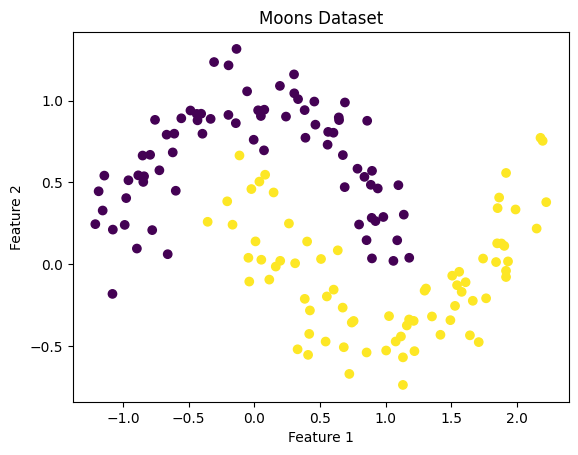

In [8]:

X, y = make_moons(150, noise=0.15, random_state=42)

# Plot the dataset
y = torch.tensor(y, dtype=float)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Moons Dataset")
print(y)